<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Information-Bottleneck-for-Decision-Trees" data-toc-modified-id="Information-Bottleneck-for-Decision-Trees-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Information Bottleneck for Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Proposal" data-toc-modified-id="Proposal-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Proposal</a></span></li><li><span><a href="#Implementation-of-the-algorithm" data-toc-modified-id="Implementation-of-the-algorithm-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Implementation of the algorithm</a></span></li><li><span><a href="#IB-Tree-estimator-properties:-consitency-and-bias" data-toc-modified-id="IB-Tree-estimator-properties:-consitency-and-bias-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>IB Tree estimator properties: consitency and bias</a></span></li><li><span><a href="#Generalization:-IB-and-VC-dimension" data-toc-modified-id="Generalization:-IB-and-VC-dimension-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Generalization: IB and VC dimension</a></span></li></ul></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#Capacity-of--a-tree" data-toc-modified-id="Capacity-of--a-tree-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Capacity of  a tree</a></span></li><li><span><a href="#Growing-a-Tree" data-toc-modified-id="Growing-a-Tree-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Growing a Tree</a></span><ul class="toc-item"><li><span><a href="#Densely-sampled-(completely-unrealistic,-but-interesting)" data-toc-modified-id="Densely-sampled-(completely-unrealistic,-but-interesting)-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Densely sampled (completely unrealistic, but interesting)</a></span></li></ul></li><li><span><a href="#Same,-but-X-is-randomly-sampled-(a-bit-closer-to-the-real-world)" data-toc-modified-id="Same,-but-X-is-randomly-sampled-(a-bit-closer-to-the-real-world)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Same, but X is randomly sampled (a bit closer to the real world)</a></span></li></ul></li><li><span><a href="#Real-world-experiment" data-toc-modified-id="Real-world-experiment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Real world experiment</a></span><ul class="toc-item"><li><span><a href="#Utils" data-toc-modified-id="Utils-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Utils</a></span></li></ul></li><li><span><a href="#Presentation" data-toc-modified-id="Presentation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Presentation</a></span></li></ul></div>

In [8]:
%load_ext autoreload
%autoreload 2
from ibtree import *
from ibtree.datasets import easy_data, caro_data, circle_data, circle_y, grid2d
from ibtree.visualize import *

import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ToggleButton(value=False, description='Show code')

# Information Bottleneck for Decision Trees

## Proposal
Decision trees are a class of machine learning algorithms that can be used for classification and regression problems. From an information theoretical perspective, they can be viewed as algorithms to construct optimal binary encodings $e: \mathcal{X} \mapsto \mathcal{B} $ for $\mathcal{B}$ being the set of binary words, and $\mathcal{X}$ being data sampled of an unkown distribution $P_X : \mathcal{X} \mapsto [0, 1]$.
It is interesting to analyze this in the information bottleneck framework (IB), which gives a justification to expect generalization.

Specifically, the following questions shall be answered:
- can we use decision trees to efficiently optimize for the IB objective? What is the time and space complexity of such an implementation?
- for which distributions $P_{X,Y}$ or probability densities $p_{X,Y}$ does this lead to a consistent unbiased estimator and for which distributions does it lead to a suboptimal estimator?
- What is the VC dimension of this algorithm? Can we find generalization bounds?
- How does this algorithm perform on different toy and real world datasets in comparison to other decision trees? How does a gradient boosted ensemble of these decision trees perform on a real world dataset, compared to a regular xgboost model?
- In the original IB paper, the authors propose the The information bottleneck iterative algorithm. How does it compare to IB trees?

## Implementation of the algorithm

The IB objective is given as
$$ J'(e) = \beta I(X, e(X)) - I(e(X), y)  = \beta ( H(X) - H(X|e(X) ) - H(y) + H(y|e(X)) $$
If we ignore all terms independent of $e$, we get:
$$ J(e) =  H(y|e(X)) - \beta H(X|e(X)) $$

It is straight forward to apply the IB method to decision trees. The first term  $H(y|e(X))$ is a widely used objective in decision trees, and the second term $\beta H(X|e(X))$ serves as a regularizer. 

In the fitting phase, the IB tree tries to find a binary split $f(x) = x_i > t$ such that $J(f)$ is minimal. If the optimal split is a constant function over the samples, all points are grouped into the same split and the (sub)tree is a leaf. In this way, pruning is no longer necessary.

The loss function for a non-leaf tree can be expressed as:


$$  J = H(y|e(X)) - \beta H(X|e(X)) $$
$$ = \sum_{i=0}^1 ( P(e(X)=i) * (H(y|e(X)=i) - \beta H(X|e(X)=i)) ) $$
$$ = P(e(X)=0) * J(left) + P(e(X)=1) * J(right) $$

The loss of a leaf is simply:

$$    J = H(y|e(X)) - \beta H(X|e(X)) $$
$$      = H(y) - \beta H(X) $$

To estimate $H(X)$, we simply assume a uniform distribution over all samples, i.e. $log(N)$.

This allows an efficient recursive computation of the loss.



## IB Tree estimator properties: consitency and bias
Notes:
- This is definitely not in general a consistent estimator: examples where the algorithm fails to converge to a good solution is given in the experimental section (caro data).
- This estimator also has a bias, since it can only express decision boundaries of the type ${x : \bigwedge\limits_{i=1}^{depth} x_i = t_i$} $ (see experiments) - it cannot accurately represent a circle and favors squared shapes in the absence of sufficient samples
- An interesting subclass of distributions are those that can be expressed perfectly by a decision tree of limited size
    - even there, the greedy optimization may get stuck in local optima (caro data problem)
    - but good news is that for most distrubitions that can be expressed, the caro data problem does not occur

## Generalization: IB and VC dimension
An upper bound for the VC dimension of a decision tree is $2^{#leaves}$.
- Given $N, \beta$, what is the VC dimension of an IB tree? Can we find an upper bound for $I(X, e(X)) \leq \psi(D)$?
- What is the implied generalization bound?

# Visualizations

1. Dataset vs optimal split Information Gain, vs IB
2. Tree learned animation with different heights

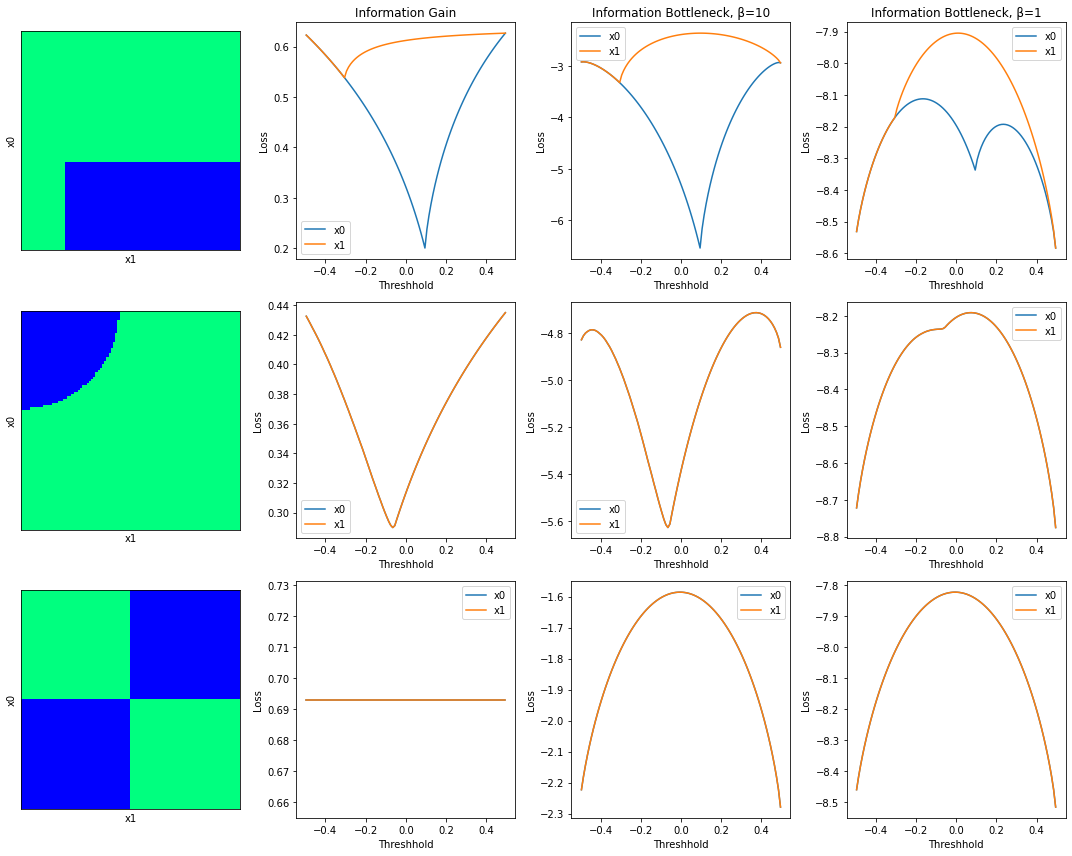

In [55]:
plt.figure(figsize=(15,12))

plt.subplot(341)
X, y = easy_data()
plot_on_grid(y[:,0], 100)

plt.subplot(342)
plt.title("Information Gain")
optimal_split_plot(X, y, entropy)

plt.subplot(343)
plt.title("Information Bottleneck, β=10")
optimal_split_plot(X, y, categorical_IB(10))

plt.subplot(344)
plt.title("Information Bottleneck, β=1")
optimal_split_plot(X, y, categorical_IB(1))


plt.subplot(345)
X, y = circle_data()
plot_on_grid(y[:,0], 100)

plt.subplot(346)
optimal_split_plot(X, y, entropy)

plt.subplot(347)
optimal_split_plot(X, y, categorical_IB(10))

plt.subplot(348)
optimal_split_plot(X, y, categorical_IB(1))

plt.subplot(349)
X, y = caro_data()
plot_on_grid(y[:,0], 100)

plt.subplot(3,4,10)
optimal_split_plot(X, y, entropy)

plt.subplot(3,4,11)
optimal_split_plot(X, y, categorical_IB(10))

plt.subplot(3,4,12)
optimal_split_plot(X, y, categorical_IB(1))

plt.tight_layout()
plt.show()

## Capacity of  a tree

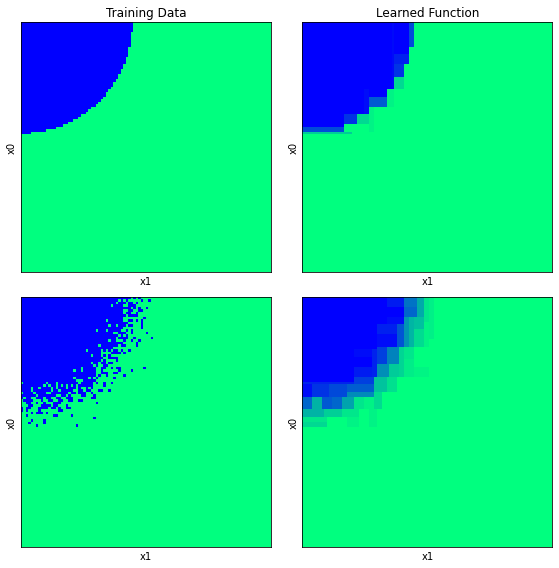

Tree with 66 leaves and depth of 10


In [53]:
from ibtree.datasets import circle_y


tree = DecisionTree(entropy, min_n=20)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title("Training Data")
plot_on_grid(y[:, 0], 100)
plt.subplot(222)
plt.title("Learned Function")
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)


y_train = circle_y(X + np.random.normal(0, 0.05, size=X.shape))
tree = DecisionTree(entropy, min_n=20)
tree.fit(X, y_train)

plt.subplot(223)
plot_on_grid(y_train[:,0], 100)

plt.subplot(224)
y_pred = tree.predict(X)       
plot_on_grid(y_pred[:, 0], 100)
plt.tight_layout()
plt.show()

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")


## Growing a Tree

### Densely sampled (completely unrealistic, but interesting)

<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

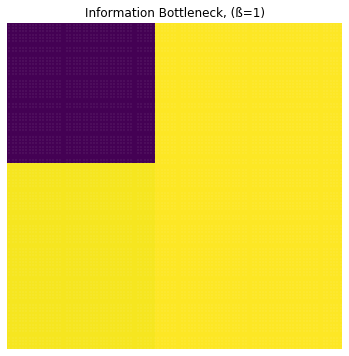

In [6]:
X, y = circle_data()
tree = DecisionTree(entropy, min_n=2)
animate_fitting(tree, X, y, "InformationGain (ß=infinity)")

tree = DecisionTree(categorical_IB(beta=10), min_n=2)
animate_fitting(tree, X, y, "Information Bottleneck, (ß=10)")

tree = DecisionTree(categorical_IB(beta=5), min_n=2)
animate_fitting(tree, X, y, "Information Bottleneck, (ß=5)")

# tree = DecisionTree(categorical_IB(beta=10), min_n=2,random_projections=20)
# animate_fitting(tree, X, y)

<Figure size 432x288 with 0 Axes>

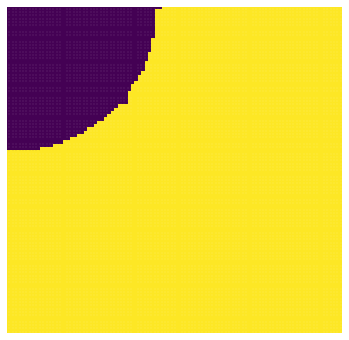

In [68]:
tree = DecisionTree(categorical_IB(beta=10), min_n=2,random_projections=10)
animate_fitting(tree, X, y)

## Same, but X is randomly sampled (a bit closer to the real world)

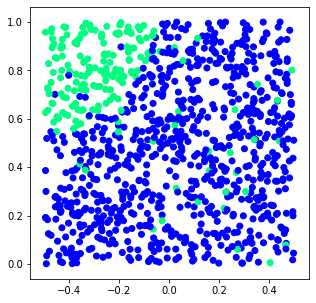

<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

In [28]:
N = 1000
X = np.random.uniform(-0.5, 0.5, size=(N,2))
y = circle_y(X)
labelnoise = np.random.rand(N)>0.05
y[labelnoise] = 1-y[labelnoise]
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], 0.5-X[:,1], c=y[:,0], cmap='winter')
plt.show()

tree = DecisionTree(entropy)
animate_fitting(tree, X, y, "InformationGain (ß=infinity)")

tree = DecisionTree(categorical_IB(beta=15))
animate_fitting(tree, X, y, "Information Bottleneck, (ß=15)")

tree = DecisionTree(categorical_IB(beta=7))
animate_fitting(tree, X, y, "Information Bottleneck, (ß=7)")
plt.clf()


# Real world experiment

## Utils

# Presentation